<a href="https://colab.research.google.com/github/maximematerno/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import pandas as pd
import numpy as np
# import seaborn as sns
# from matplotlib import style
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel
from scipy import stats

In [59]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', 
                 header=None,
                 names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [60]:
df= df.replace({'?':np.NaN, 'n':0, 'y':1})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [61]:
df.isnull().sum()

party                     0
handicapped-infants      12
water-project            48
budget                   11
physician-fee-freeze     11
el-salvador-aid          15
religious-groups         11
anti-satellite-ban       14
aid-to-contras           15
mx-missile               22
immigration               7
synfuels                 21
education                31
right-to-sue             25
crime                    17
duty-free                28
south-africa            104
dtype: int64

In [62]:
rep = df[df.party == 'republican']
print(rep.shape)
rep.head()

(168, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [63]:
dem = df[df.party=='democrat']
print(dem.shape)
dem.head()

(267, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [64]:
df.party.value_counts()

democrat      267
republican    168
Name: party, dtype: int64

In [0]:
df=df.fillna(0)

In [66]:
print(df['water-project'].shape)


(435,)


In [67]:
sample_Water_project= df['water-project'].sample(100)
print(sample_Water_project.shape)
sample_Water_project.head()

(100,)


349    1.0
248    0.0
18     1.0
180    0.0
222    0.0
Name: water-project, dtype: float64

In [0]:
def confidence_interval(data, confidence_level=0.95):

  data = np.array(data)
  sample_mean = np.mean(data)
  sample_size = len(data)
  sample_std_dev = np.std(data, ddof=1)
  standard_error = sample_std_dev / (sample_size**.5)
  margin_of_error = standard_error * stats.t.ppf((1 + confidence_level) / 2.0, sample_size - 1)
  return (sample_mean, sample_mean - margin_of_error, sample_mean + margin_of_error)

In [69]:
confidence_interval(sample_Water_project)

(0.51, 0.4103092906280824, 0.6096907093719176)

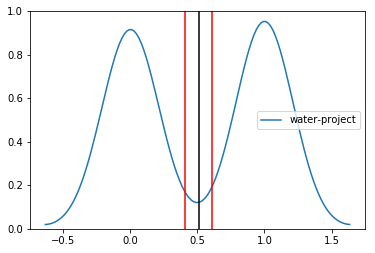

In [72]:
import seaborn as sns


sns.kdeplot(sample_Water_project)
CI= confidence_interval(sample_Water_project)
plt.axvline(x=CI[1], color='red')
plt.axvline(x=CI[2], color='red')
plt.axvline(x=CI[0], color='k');

#3. Interpret Confidence Interval
Confidence Interval == Bounds of statistical significance for our t-test
A sample mean that falls inside of our confidence interval will "FAIL TO REJECT" our null hypothesis
A sample mean that falls outside of our confidence interval will "REJECT" our null hypothesis

#Chi-squared tests:

##By hand using Numpy

In [73]:
#4. Chi-test

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [75]:
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [76]:
cut_points = [0, 9, 19, 29, 39, 49, 1000]
label_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels=label_names)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,40-49
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,10-19
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,40-49
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,40-49
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,40-49


In [77]:
df['salary'].value_counts()

 <=50K    24720
 >50K      7841
Name: salary, dtype: int64

In [78]:
df['hours_per_week_categories'].value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

In [83]:
df = df.sort_values(by='hours_per_week_categories', ascending=True)
contingency_table = pd.crosstab(df['salary'], df['hours_per_week_categories'], margins=True)
contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
salary,,,,,,,
<=50K,413,1174,2239,3199,14013,3682,24720
>50K,45,72,153,468,4323,2780,7841
All,458,1246,2392,3667,18336,6462,32561


In [85]:
less_or_egal_50k = contingency_table.iloc[0][0:6]
less_or_egal_50k

hours_per_week_categories
0-9        413
10-19     1174
20-29     2239
30-39     3199
40-49    14013
50+       3682
Name:  <=50K, dtype: int64

In [88]:
more_than_50k = contingency_table.iloc[1][0:6]
more_than_50k 

hours_per_week_categories
0-9        45
10-19      72
20-29     153
30-39     468
40-49    4323
50+      2780
Name:  >50K, dtype: int64

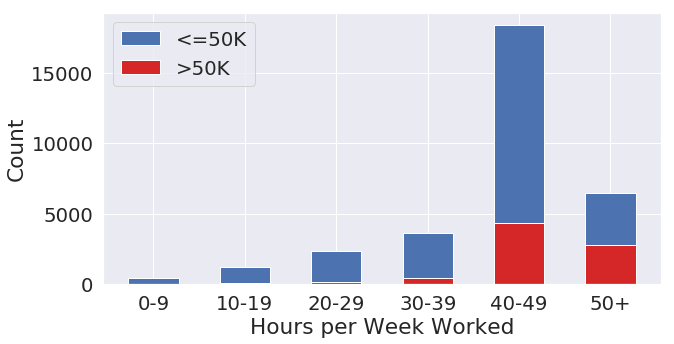

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plots the bar chart
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
categories = ["0-9","10-19","20-29","30-39","40-49","50+"]
p1 = plt.bar(categories, more_than_50k, 0.55, color='#d62728')
p2 = plt.bar(categories, less_or_egal_50k, 0.55, bottom=more_than_50k)
plt.legend((p2[0], p1[0]), ('<=50K', '>50K'))
plt.xlabel('Hours per Week Worked')
plt.ylabel('Count')
plt.show()

In [90]:
row_sums = contingency_table.iloc[0:2, 6].values
col_sums = contingency_table.iloc[2, 0:6].values

print(row_sums)
print(col_sums)

[24720  7841]
[  458  1246  2392  3667 18336  6462]


In [91]:
total = contingency_table.loc['All','All']
total

32561

In [92]:
len(df)

32561

In [93]:
df.shape[0]

32561

In [94]:
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
  

expected = np.array(expected)
print(expected.shape)  
print(expected)

(2, 6)
[[  347.70922269   945.95129142  1815.98353859  2783.95135285
  13920.51595467  4905.88863978]
 [  110.29077731   300.04870858   576.01646141   883.04864715
   4415.48404533  1556.11136022]]


In [95]:
observed = pd.crosstab(df['salary'], df['hours_per_week_categories']).values
print(observed.shape)
observed

(2, 6)


array([[  413,  1174,  2239,  3199, 14013,  3682],
       [   45,    72,   153,   468,  4323,  2780]])

In [96]:
chi_squared = ((observed - expected)**2/(expected)).sum()
print(f"Chi-Squared: {chi_squared}")

Chi-Squared: 2215.839963859004


In [97]:
dof = (len(row_sums)-1)*(len(col_sums)-1)
print(f"Degrees of Freedom: {dof}")   

Degrees of Freedom: 5


##In a single line using Scipy

In [99]:
df= pd.crosstab(df['salary'], df['hours_per_week_categories']).values
print(df.shape)
df

(2, 6)


array([[  413,  1174,  2239,  3199, 14013,  3682],
       [   45,    72,   153,   468,  4323,  2780]])

In [100]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(df)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 2215.839963859004
P-value: 0.0
Degrees of Freedom: 5
Expected: 
 [[  347.70922269   945.95129142  1815.98353859  2783.95135285
  13920.51595467  4905.88863978]
 [  110.29077731   300.04870858   576.01646141   883.04864715
   4415.48404533  1556.11136022]]


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)